In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [12]:
df = pd.read_csv('AEP_hourly.csv')

In [14]:
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [18]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [20]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [22]:
print("First few rows of the DataFrame:")
print(df.head())

First few rows of the DataFrame:
             Datetime   AEP_MW
0 2004-12-31 01:00:00  13478.0
1 2004-12-31 02:00:00  12865.0
2 2004-12-31 03:00:00  12577.0
3 2004-12-31 04:00:00  12517.0
4 2004-12-31 05:00:00  12670.0


In [24]:
print("\nDatatype of Datetime column:")
print(df['Datetime'].dtype)


Datatype of Datetime column:
datetime64[ns]


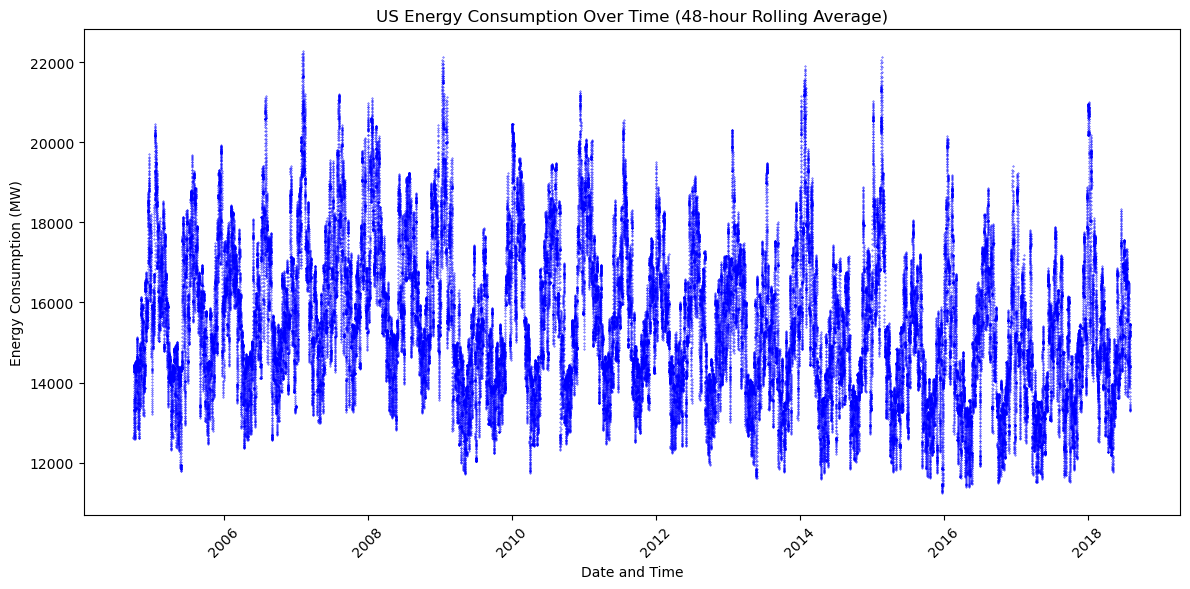

In [37]:
plt.clf()
plt.close('all')

df['rolling_average_48h'] = df['AEP_MW'].rolling(window=48).mean()

# Create a scatter plot with very small points
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df['Datetime'], df['rolling_average_48h'], 
           s=0.1,  
           color='blue')

ax.set_title('US Energy Consumption Over Time (48-hour Rolling Average)')
ax.set_xlabel('Date and Time')
ax.set_ylabel('Energy Consumption (MW)')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

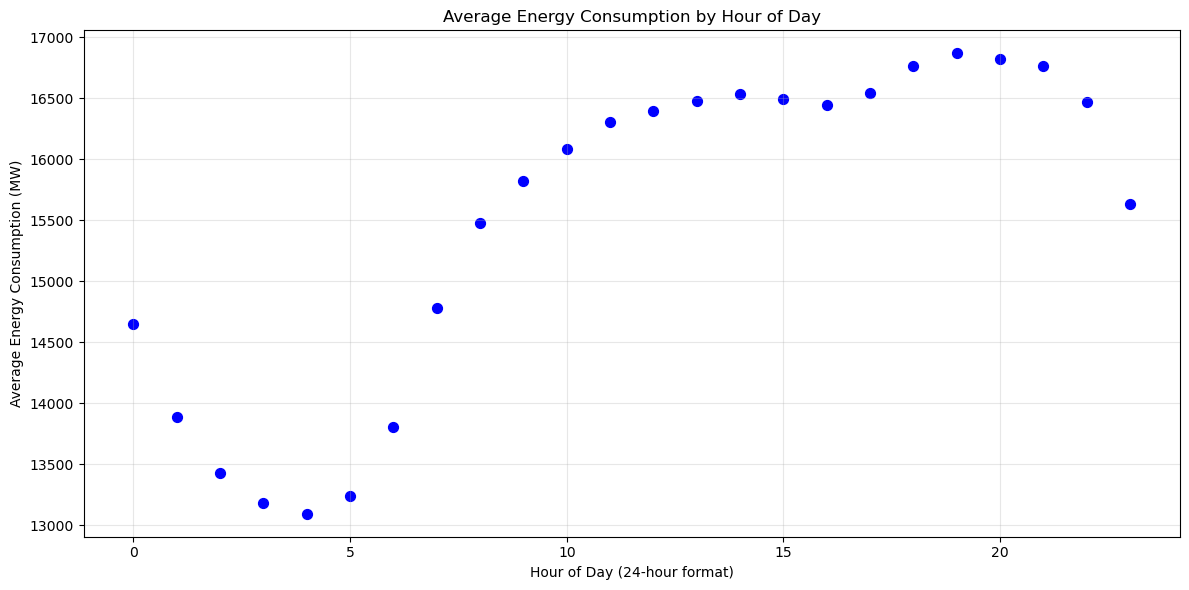

In [28]:
df['hour'] = df['Datetime'].dt.hour

hourly_avg = df.groupby('hour')['AEP_MW'].mean().reset_index()

plt.clf()
plt.close('all')

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(hourly_avg['hour'], hourly_avg['AEP_MW'],
           color='blue', s=50)
ax.set_title('Average Energy Consumption by Hour of Day')
ax.set_xlabel('Hour of Day (24-hour format)')
ax.set_ylabel('Average Energy Consumption (MW)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show

In [30]:
# Basic statistics for each hour
print("Hourly Statistics:")
print(hourly_avg.describe())

# Find peak and minimum hours
peak_hour = hourly_avg.loc[hourly_avg['AEP_MW'].idxmax()]
min_hour = hourly_avg.loc[hourly_avg['AEP_MW'].idxmin()]

print("\nPeak Usage Hour:", peak_hour['hour'])
print("Minimum Usage Hour:", min_hour['hour'])

Hourly Statistics:
            hour        AEP_MW
count  24.000000     24.000000
mean   11.500000  15499.125916
std     7.071068   1349.637181
min     0.000000  13095.193350
25%     5.750000  14461.263285
50%    11.500000  16195.299763
75%    17.250000  16503.273034
max    23.000000  16868.728334

Peak Usage Hour: 19.0
Minimum Usage Hour: 4.0


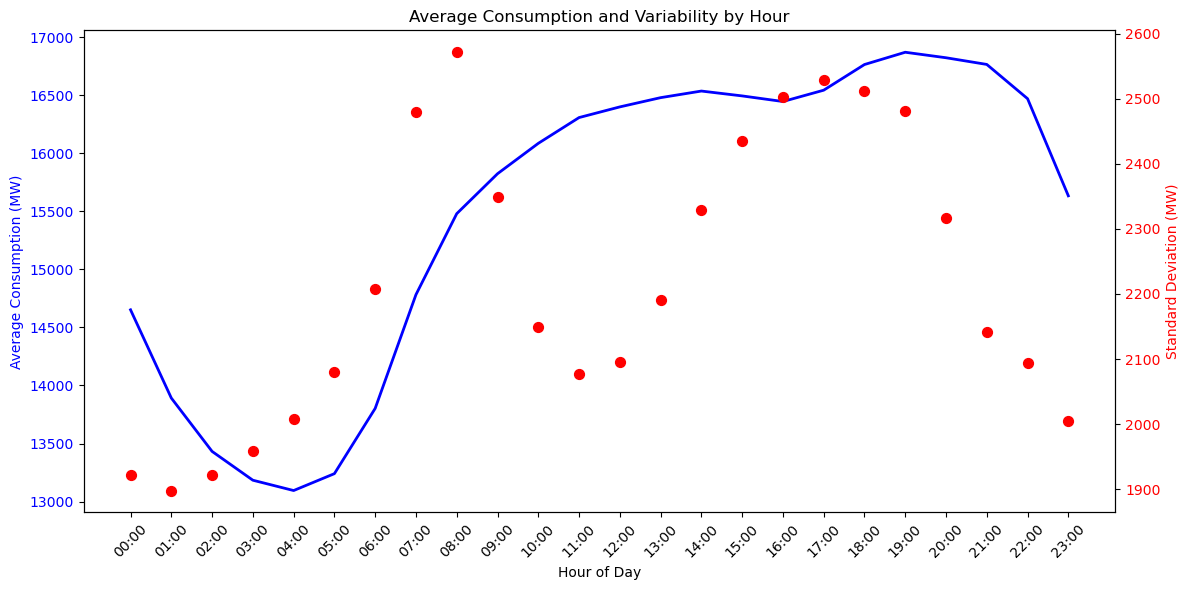

In [39]:
plt.clf()
plt.close('all')

fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'blue'
ax1.plot(hourly_avg['hour'], hourly_avg['AEP_MW'], 
         color=color1, 
         label='Mean Consumption',
         linewidth=2)
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Consumption (MW)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax1.set_xticks(range(0, 24))
ax1.set_xticklabels([str(i).zfill(2) + ':00' for i in range(24)], rotation=45)

ax2 = ax1.twinx()
color2 = 'red'
ax2.scatter(hourly_std['hour'], hourly_std['AEP_MW'], 
            color=color2, 
            label='Standard Deviation',
            s=50)
ax2.set_ylabel('Standard Deviation (MW)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Average Consumption and Variability by Hour')
plt.tight_layout()
plt.show()